In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
df = pd.read_csv("C:\\progetti\\low-code-ard-proj\\resyduo_components\\transformation_component\\transformation_storage\\tag_data\\surprise_tag_comp_cut_1_1.csv") 

In [3]:
df.head()

,tagID,componentID,rating
0,plc,Chinese voltage regulator module,0
1,plc,5mm Red LED (Through-hole),0
2,plc,5 PIN DIN jack,0
3,plc,Nut M3,0
4,plc,Rubber feet,0


In [4]:
df = df[df.rating != 0] 

In [6]:
df.head()

,tagID,componentID,rating
1794,plc,Arduino Ethernet Shield 2,1
4710,plc,9V 1A Switching Wall Power Supply,1
5564,plc,Alphanumeric LCD 20 x 4,1
5987,plc,Jumper wires (generic),1
6195,plc,Arduino Mega 2560,1


In [7]:
df.shape

(82201, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82201 entries, 1794 to 36527032
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tagID        82201 non-null  object
 1   componentID  82201 non-null  object
 2   rating       82201 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [9]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (82201, 3)
-Dataset examples-
     tagID                componentID  rating
1794   plc  Arduino Ethernet Shield 2       1


## EDA

### Ratings Distribution

In [10]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

ModuleNotFoundError: No module named 'plotly'

We can see that over 62% of all ratings in the data are 0, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

In [ ]:
df.columns

Index(['tagID', 'componentID', 'rating'], dtype='object')

In [ ]:
# Number of ratings per book
data = df.groupby('componentID')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Components (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Components'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
df.groupby('componentID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,componentID,rating
2834,Arduino UNO,2019
2791,Arduino Nano R3,1130
5373,Jumper wires (generic),1068
3209,Breadboard (generic),823
5575,LED (generic),638
8062,Resistor 10k ohm,613
2763,Arduino Mega 2560,612
3282,Buzzer,462
10385,Ultrasonic Sensor - HC-SR04 (Generic),460
8076,Resistor 1k ohm,419


Most of the books received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings.

### Ratings Distribution By User

In [ ]:
# Number of ratings per user
data = df.groupby('componentID')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
df.groupby('componentID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,componentID,rating
2834,Arduino UNO,2019
2791,Arduino Nano R3,1130
5373,Jumper wires (generic),1068
3209,Breadboard (generic),823
5575,LED (generic),638
8062,Resistor 10k ohm,613
2763,Arduino Mega 2560,612
3282,Buzzer,462
10385,Ultrasonic Sensor - HC-SR04 (Generic),460
8076,Resistor 1k ohm,419


Most of the users gave less than 5 ratings, and very few users gave many ratings, although the most productive user have given 13,602 ratings.

I'm sure you have noticed that the above two charts share the same distribution. The number of ratings per movie and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users.

In [ ]:
df.groupby('componentID')['rating'].count().reset_index().sort_values('rating', ascending=True)[:10]

,componentID,rating
5821,LiPo 2 cell battery,2
5121,IOT relay,2
5122,IOT2020 3D Printed LCD Cover by Frederick Vand...,2
5124,IP67 Rated Dome Pushbutton,2
5128,IR Break Beam Sensor,2
5130,IR Emitter Module,2
5136,IR Infrared Obstacle Avoidance Sensor Module,2
5144,IR Proximity (Industrial) 12V,2
5150,IR Remote - Generic,2
5107,ILI9341 TFT Display,2


In [ ]:
min_book_ratings = 2
filter_books = df['componentID'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 2
filter_users = df['tagID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['componentID'].isin(filter_books)) & (df['tagID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(82201, 3)
The new data frame shape:	(78422, 3)


## Surprise

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [ ]:
reader = Reader(rating_scale=(2, 2019))
data = Dataset.load_from_df(df_new[['tagID', 'componentID', 'rating']], reader)

With the Surprise library, we will benchmark the following algorithms

### Basic algorithms

#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

* KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

#### KNNWithZScore

* KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### SVDpp

* The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

### Co-clustering

* Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)


We use rmse as our accuracy metric for the predictions.

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\metho\AppData\Local\Temp\ipykernel_20772\1905352812.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
NMF,2.774026,1.998185,0.159659
BaselineOnly,4.944605,0.133493,0.068184
CoClustering,5.430748,1.911586,0.089118
KNNWithZScore,6.199396,0.478470,1.842888
NormalPredictor,6.229014,0.057885,0.142825
KNNWithMeans,6.987650,0.376256,1.706818
KNNBasic,7.047917,0.322773,1.715310
KNNBaseline,7.349709,0.513833,2.042229
SlopeOne,11.273484,2.367413,3.533291


BaselineOnly algorithm gave us the best rmse, therefore, we will proceed further with BaselineOnly and use Alternating Least Squares (ALS).

In [ ]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([5.08717695, 5.50001302, 4.2683697 ]),
 'fit_time': (0.07177925109863281, 0.07998967170715332, 0.08155345916748047),
 'test_time': (0.28363990783691406, 0.07579255104064941, 0.06585812568664551)}

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 6.1272


6.127221173197259

In [ ]:
len(predictions)

19606

In [ ]:
# dump.dump('./dump_file', predictions, algo)
# predictions, algo = dump.load('./dump_file')

In [ ]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [ ]:
uid = str("display")  # raw user id (as in the ratings file). They are **strings**!
iid = str("Nut M3")  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: display    item: Nut M3     r_ui = None   est = 2.00   {'was_impossible': False}


In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
df.head(100)

,uid,iid,rui,est,details,Iu,Ui,err
0,motor,Male/Male Jumper Wires,4.0,2.673396,{'was_impossible': False},324,107,1.326604
1,cayenne,Arduino Ethernet Shield 2,1.0,2.000000,{'was_impossible': False},23,69,1.000000
2,tcrt5000,5k Ohm resistor,1.0,2.000000,{'was_impossible': False},2,1,1.000000
3,internet of things,LiPo 3.7v battery,2.0,2.400015,{'was_impossible': False},1225,2,0.400015
4,led matrix,Jumper wires (generic),14.0,4.377167,{'was_impossible': False},131,802,9.622833
...,...,...,...,...,...,...,...,...
95,opl iot,Axial Fan 12 VDC,1.0,2.000000,{'was_impossible': False},1,11,1.000000
96,alexa,LED Ring,1.0,2.000000,{'was_impossible': False},37,1,1.000000
97,home automation,Active Buzzer Module for Arduino,1.0,3.152572,{'was_impossible': False},1618,1,2.152572
98,sensor,Analog Devices Instrumentation Amplifier SO-8 ...,1.0,2.000000,{'was_impossible': False},584,3,1.000000


In [ ]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
df.index

RangeIndex(start=0, stop=19606, step=1)

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
7459,ros,16x2 LCD Shield,2.0,2.0,{'was_impossible': False},37,4,0.0
9025,strip,Resistor 330 ohm,2.0,2.0,{'was_impossible': False},9,214,0.0
9026,environmental sensing,Texas Instruments General Purpose Quad Op-Amp,2.0,2.0,{'was_impossible': False},662,13,0.0
18028,internet of things,Arduino MKR MEM Shield,2.0,2.0,{'was_impossible': False},1225,6,0.0
1812,conductive tape,Hook Up Wire Kit 22 AWG,2.0,2.0,{'was_impossible': False},6,40,0.0
19109,garden,Linear Regulator (7805),2.0,2.0,{'was_impossible': False},227,115,0.0
9090,machine learning,Adafruit Micro-Lipo Charger,2.0,2.0,{'was_impossible': False},205,4,0.0
1868,diy,Arduino Leonardo,2.0,2.0,{'was_impossible': False},115,106,0.0
1887,pir sensor,PIR Sensor 7 m,2.0,2.0,{'was_impossible': False},31,20,0.0
5950,wearables,Buzzer Piezo,2.0,2.0,{'was_impossible': False},333,51,0.0


The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 26 to 146, they are not really small, meaning that significant number of users have rated the target book.

In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2120,smart appliances,Jumper wires (generic),100.0,5.482466,{'was_impossible': False},682,802,94.517534
5244,lights,Arduino Nano R3,110.0,5.286205,{'was_impossible': False},687,805,104.713795
237,led,LED (generic),113.0,4.658363,{'was_impossible': False},879,476,108.341637
14328,internet of things,Breadboard (generic),122.0,5.250772,{'was_impossible': False},1225,650,116.749228
10633,robotics,Jumper wires (generic),134.0,5.454573,{'was_impossible': False},1313,802,128.545427
6827,robotics,Arduino Nano R3,134.0,5.182968,{'was_impossible': False},1313,805,128.817032
4393,sensor,Arduino UNO,140.0,6.842412,{'was_impossible': False},584,1375,133.157588
7842,internet of things,Jumper wires (generic),189.0,5.369292,{'was_impossible': False},1225,802,183.630708
14122,arduino,Arduino UNO,271.0,7.234390,{'was_impossible': False},696,1375,263.765610
14146,internet of things,Arduino UNO,310.0,7.437810,{'was_impossible': False},1225,1375,302.562190


The worst predictions look pretty surprise. Let's look in more details of the last one ISBN "055358264X", the book was rated by 47 users, user "26544" rated 10, our BaselineOnly algorithm predicts 0.

In [ ]:
df_new.loc[df_new['componentID'] == 'Rubber feet']['rating'].describe()

count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: rating, dtype: float64

In [ ]:
df.loc[df['uid'] == 'display']

,uid,iid,rui,est,details,Iu,Ui,err
25,display,Resistor 10k ohm,33.0,4.003873,{'was_impossible': False},697,462,28.996127
59,display,WS2812B x 60 1M led strip,1.0,2.038832,{'was_impossible': False},697,2,1.038832
109,display,Hook Up Wire Kit 18 AWG,1.0,2.085523,{'was_impossible': False},697,4,1.085523
158,display,HC-06 Bluetooth Module,1.0,2.740340,{'was_impossible': False},697,106,1.740340
184,display,ElectroPeak 0.96inch SPI 128X64 OLED Display M...,1.0,2.219570,{'was_impossible': False},697,2,1.219570
...,...,...,...,...,...,...,...,...
19421,display,Adafruit 4 Pin JST SM plug and connector,1.0,2.102008,{'was_impossible': False},697,1,1.102008
19460,display,Machine header,1.0,2.147631,{'was_impossible': False},697,1,1.147631
19461,display,Solderless Breadboard Half Size,11.0,2.661301,{'was_impossible': False},697,126,8.338699
19469,display,Adafruit Digital RGB LED Weatherproof Strip,1.0,2.000000,{'was_impossible': False},697,2,1.000000


In [ ]:
df_new.groupby('tagID')['rating'].count().reset_index().sort_values('rating', ascending=True)[:100]

,tagID,rating
350,autonomous vessel,1
1044,geiger,1
1695,muller,1
2360,software architecuture,1
642,controleverything,1
...,...,...
329,autodesk,3
330,autogenerative,3
1893,pianomidi,3
1889,physical web,3


In [ ]:
df.loc[df['uid'] == 'pianomidi']

,uid,iid,rui,est,details,Iu,Ui,err
17799,pianomidi,Arduino UNO,1.0,6.484449,{'was_impossible': False},2,1375,5.484449


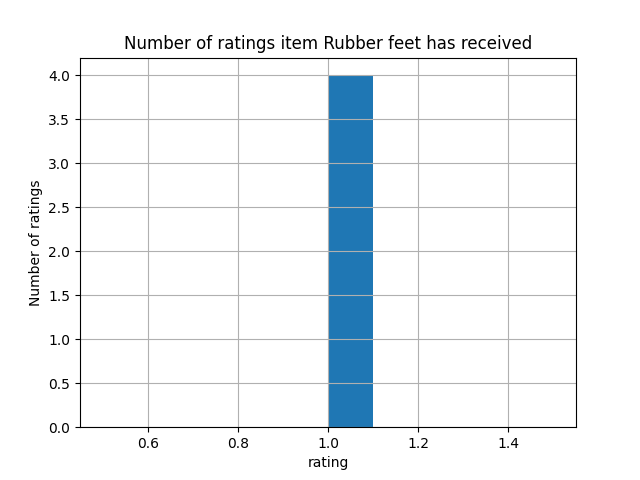

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['componentID'] == 'Rubber feet']['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings item Rubber feet has received')
plt.show();

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only very few users rated "10". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.random.normal(170, 10, 250)

plt.hist(x)
plt.show() 

<IPython.core.display.Javascript object>